CREAZIONE DI UN CLASSIFICATORE PER DOCUMENTI TESTUALI

SET UP LIBRERIE

In [1]:
from pathlib import Path
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

SET UP DATASET

Dopo aver caricato il dataset nel notebook in formato .zip, lo estraiamo dall'archivio. Si otterrà un'alberatura di cartelle come segue:

DATASET
> corpus
>>business

>>entertainment

>>food

>>graphics

>>historical

>>medical

>>politics

>>space

>>sport

>>technologie


In [ ]:
!unzip /content/DATASET.zip

Creiamo una enumerazione per rappresentare le varie categorie/label.

In [3]:
from enum import Enum

class Categories(Enum):
  business=0
  entertainment=1
  food=2
  graphics=3
  historical=4
  medical=5
  politics=6
  space=7
  sport=8
  technologie=9

TEST AND TRAIN SETS

Creiamo gli insiemi di addestramento e test a partire dai documenti a disposizione.

Per ogni categoria, i documenti con numerazione *3, *5, *7 verranno assegnati all'insieme di training, gli altri a quello di test.

In questo modo, useremo il 30% dei documenti per l'addestramento. Metteremo alla prova il classificatore sul restante 70%.

In [4]:
train_corpus = []
test_corpus = []

for child in Path('/content/DATASET/corpus').glob('**/*.txt'):
    if child.is_file():
      splitted_filename = child.name.split("_")
      doc_name = splitted_filename[0]
      doc_number = splitted_filename[1].split(".")[0]
      if doc_number[len(doc_number)-1] == "3" or doc_number[len(doc_number)-1] == "5" or doc_number[len(doc_number)-1] == "7":
        train_corpus.append((child.name, child.read_text().replace("\n", " "), Categories[child.name.split("_")[0]].value))
      else:
        test_corpus.append((child.name, child.read_text().replace("\n", " "), Categories[child.name.split("_")[0]].value))

In [5]:
print("Dimensione insieme di training: ", len(train_corpus))
print("Dimensione insieme di test: ", len(test_corpus))

Dimensione insieme di training:  300
Dimensione insieme di test:  700


SET UP DATAFRAMES

Per comodità, trasformiamo i vettori di documenti in dataset, più facili da manipolare.

In [6]:
df_train = pd.DataFrame(train_corpus, columns=['document', 'text', 'category'])
df_test = pd.DataFrame(test_corpus, columns=['document', 'text', 'category'])

In [7]:
df_train

,document,text,category
0,graphics_47.txt,In article <o4fzrApDBh107h@eosvcr.wimsey.bc.ca...,3
1,graphics_3.txt,Create Incredible Branding Initiatives Without...,3
2,graphics_83.txt,7 Best Free Tools Allows You to Create Profess...,3
3,graphics_67.txt,In article <734553308snx@rjck.UUCP> rob@rjck.U...,3
4,graphics_97.txt,"Sorry I missed you Raymond, I was just out in ...",3
...,...,...,...
295,space_15.txt,> there is no such thing as a stable lunar orb...,7
296,space_85.txt,">Date: Tue, 6 Apr 1993 15:40:47 GMT >I need as...",7
297,space_37.txt,How 'bout some more info on that alleged super...,7
298,space_93.txt,"In article <VNci2B7w165w@inqmind.bison.mb.ca>,...",7


In [8]:
df_test

,document,text,category
0,graphics_61.txt,How does the 16 bit color of HDTV work ? It ca...,3
1,graphics_92.txt,Dominic Lai (cs_cylai@cs.ust.hk) wrote: : Simo...,3
2,graphics_56.txt,In article <1993Apr10.160929.696@galki.toppoin...,3
3,graphics_4.txt,"Hello, I am looking to add voice input ca...",3
4,graphics_49.txt,"No design skills needed Usually, some people w...",3
...,...,...,...
695,space_50.txt,nsmca@aurora.alaska.edu writes: [Excellent dis...,7
696,space_99.txt,NASA Headquarters distributed the following pr...,7
697,space_8.txt,nanderso@Endor.sim.es.com (Norman Anderson) wr...,7
698,space_44.txt,"In article <C4zHKw.3Dn@zoo.toronto.edu>, henry...",7


VETTORIZZAZIONE

Convertiamo il testo nei documenti in valori numerici, applicando sostanzialmente l'approccio Bag of Words.

I testi, ripuliti dalle stop words, saranno trasformati in un insieme di feature numeriche.

In [9]:
vectorizer = CountVectorizer(stop_words="english")

In [10]:
X_train = vectorizer.fit_transform(df_train.text, df_train.category).toarray()
y_train = df_train.category
X_train.shape

(300, 14774)

In [11]:
X_test = vectorizer.transform(df_test.text).toarray()
y_test = df_test.category
X_test.shape

(700, 14774)

COSTRUZIONE DEL CLASSIFICATORE

A questo punto, scegliamo di costruire un classificatore Naive Bayes di tipo multinomiale, addestrato sui dati di training.

In [12]:
clf = MultinomialNB().fit(X_train, y_train)

Proviamo a sottoporgli delle frasi inventate sul momento, noteremo che le previsioni del classificatore presentano una buona accuratezza.

In [13]:
print(Categories(clf.predict(vectorizer.transform(["the risk of cancer increases after 60 years of age"]))).name)

medical


In [14]:
print(Categories(clf.predict(vectorizer.transform(["Policy of media was shaped by Italy pm Silvio Berlusconi, great friend of Tony Blair."]))).name)

politics


Sottoponiamo ora al classificatore un documento scelto a caso dall'insieme di test, e verifichiamo che sia assegnato alla categoria corretta.

In [15]:
filename = '/content/DATASET/corpus/space/space_36.txt'
file_text = ""
with open(filename, 'r') as reader:
    file_text = reader.read()
print(file_text)

This might a real wierd idea or maybe not..
I have seen where people have blown up ballons then sprayed material into them
that then drys and makes hard walls...
Why not do the same thing for a space station..
Fly up the docking rings and baloon materials and such, blow up the baloons,
spin then around (I know a problem in micro gravity) let them dry/cure/harden?
and cut a hole for the docking/attaching ring and bingo a space station..
Of course the ballons would have to be foil covered or someother radiation
protective covering/heat shield(?) and the material used to make the wals would
have to meet the out gasing and other specs or atleast the paint/covering of
the inner wall would have to be human safe.. Maybe a special congrete or maybe
the same material as makes caplets but with some changes (saw where someone
instea dof water put beer in the caplet mixture, got a mix that was just as
strong as congret but easier to carry around and such..)
Sorry for any spelling errors, I missed 

In [16]:
print(Categories(clf.predict(vectorizer.transform([file_text]))).name)

space


Passiamo ora alla classificazione dell'intero insieme di test.
Il classificatore mostra una precisione del 94%.

In [17]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.9385714285714286


Visualizziamo il risultato con una confusion matrix.

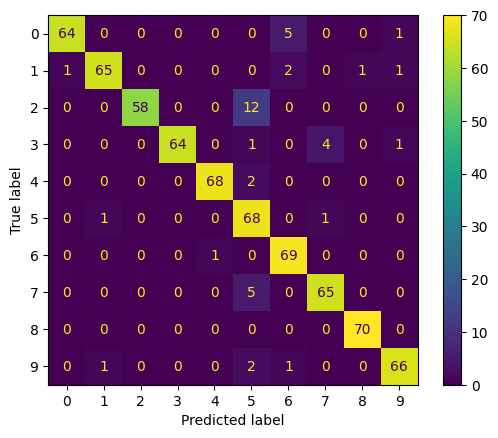

In [18]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot();

657 documenti su 700 correttamente classificati

Il risultato ottenuto, come visto, ha fatto uso dell'approccio Bag of Words. Proviamo ora ad adoperare invece la Tf-IDF come possibile miglioramento.

Il processo è analogo al precedente, con la differenza di utilizzare TfidfTransformer al posto di CountVectorizer.

In [19]:
vectorizer = CountVectorizer(stop_words="english")
tfidf_transformer = TfidfTransformer()

X_tf_train = vectorizer.fit_transform(df_train.text, df_train.category).toarray()
y_train = df_train.category
X_idf_train = tfidf_transformer.fit_transform(X_tf_train)
X_idf_train.shape

(300, 14774)

In [20]:
clf_idf = MultinomialNB().fit(X_idf_train, y_train)

Delle prove superficiali ottengono risposte accettabili.

In [21]:
print(Categories(clf.predict(vectorizer.transform(["Mediterranean diet is among the healthiest in the world, thanks to small comsumption of meet and a lot of vegetables."]))).name)

medical


In [22]:
print(Categories(clf.predict(vectorizer.transform(["Photoshop is the best program to manipulate pictures, Revit is best for renderings."]))).name)

graphics


In [23]:
X_tf_test = vectorizer.transform(df_test.text).toarray()
y_test = df_test.category
X_idf_test = tfidf_transformer.transform(X_tf_test)
X_idf_test.shape

(700, 14774)

Verifichiamo che effettivamente la precisione del cassificatore sia aumentata di poco più dell'1%. Un miglioramento lieve, ma comunque rilevabile, a fronte di una precisione già superiore al 90%.

In [24]:
y_idf_pred = clf.predict(X_idf_test)
accuracy = accuracy_score(y_idf_pred, y_test)
accuracy

0.9528571428571428

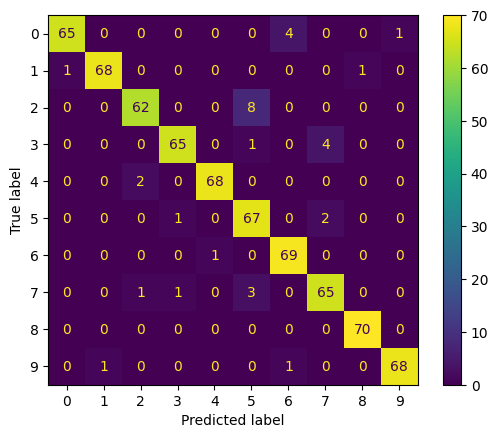

In [25]:
cm = confusion_matrix(y_test, y_idf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot();